# <span style="color:blue">Explainable AI in Natural Language Processing - RNN Training Notebook</span>

## RNN Keras Implementation & Training



Author: Amir Mozahebi <br>
Thesis: Evaluating Sequence Learning Models for Identifying Hate Speech using Explainable AI

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Model
from keras.utils import plot_model
import keras_tuner
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
from time import time
import os, shutil
import gc

In [2]:
%store -r sequenceLength
%store -r vocabSize
%store -r paddedTrainSequences
%store -r trainLabels
%store -r paddedTestSequences
%store -r testLabels
%store -r tokenizer

In [3]:
print("Sequence Length: " + str(sequenceLength))
print("Vocab Size: " + str(vocabSize))
print(trainLabels[:5])

Sequence Length: 25
Vocab Size: 28829
23943    1
15123    1
4213     2
18820    1
6261     2
Name: label, dtype: int64


In [4]:
len(paddedTestSequences)

10796

In [5]:
trainLabels = tf.keras.utils.to_categorical(trainLabels, num_classes=3)
testLabels_backup = testLabels
testLabels = tf.keras.utils.to_categorical(testLabels, num_classes=3)

In [6]:
trainLabels[0]

array([0., 1., 0.], dtype=float32)

In [7]:
#Define function to plot the history of the model training (accuracy + loss)
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

In [8]:
def plotConfusionMatrix(cm):
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(3,3)

    ax = sns.heatmap(cm, annot=labels, fmt="",cmap='Blues')

    ax.set_title('Confusion Matrix \n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values \n');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Hatespeech','Offensive', 'Neither'])
    ax.yaxis.set_ticklabels(['Hatespeech','Offensive', 'Neither'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

## RNN Model Tuning - Using Keras Tuner to optimize hyperparameters 

In [9]:
# Callback to use garbage collector after each epoch to improve memory usage
class GCCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [10]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.models.Sequential()
        model.add(layers.Embedding(vocabSize, output_dim=hp.Int("output_dim", min_value=32, max_value=512, step=16), input_length=sequenceLength))
        model.add(layers.SimpleRNN(units=hp.Int("units", min_value=32, max_value=512, step=16)))
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=hp.Float("rate", min_value=0.1, max_value=0.5)))
        model.add(layers.Dense(3,activation="sigmoid"))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
            loss='binary_crossentropy',
            metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            **kwargs,
        )

In [11]:
# Define model hyperparameters before tuning
def buildModel(hp):
    model = keras.models.Sequential()
    model.add(layers.Embedding(vocabSize, output_dim=hp.Int("output_dim", min_value=32, max_value=512, step=16), input_length=sequenceLength))
    model.add(layers.SimpleRNN(units=hp.Int("units", min_value=32, max_value=512, step=16)))
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=hp.Float("rate", min_value=0.1, max_value=0.5)))
    model.add(layers.Dense(3,activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss='binary_crossentropy',
        metrics=["accuracy"],
    )
    return model

In [12]:
# Method to delete files in log directory
def cleanLogs(path):
    folder = path
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [13]:
def tuneModels(epoch_min, epoch_max, step, X_train, X_label, Y_train, Y_label, num_trials):
    
    tuners = []
    best_model_by_epoch = []
    counter=0
    
    for i in range(epoch_min, epoch_max, step):
        counter += 1
        logPath = "training_logs/rnn_logs/tb_logs_rnn_tuner_" + str(counter)
        #cleanLogs(logPath)
        tuner = keras_tuner.BayesianOptimization(
        buildModel,
        objective='val_accuracy',
        max_trials=num_trials,
        overwrite = True,
        directory='../tuner_dir/rnn_tuner_' + str(counter))
        buildModel(keras_tuner.HyperParameters())
        tuner.search(X_train, X_label, epochs=i, validation_data=(paddedTestSequences, testLabels),
        callbacks=[keras.callbacks.TensorBoard(logPath)])
        tuners.append(tuner)
        
    for tuner in tuners:
        model = tuner.get_best_models(num_models=1)
        best_model_by_epoch.append(model[0])
            
    return tuners, best_model_by_epoch

In [14]:
def tuneModelByEpoch(epochs, X_train, X_label, Y_train, Y_label, num_trials, logPathCounter):
     
    logPath = "training_logs/rnn_logs/tb_logs_rnn_tuner_" + str(logPathCounter)
    cleanLogs(logPath)
        
    tuner = keras_tuner.BayesianOptimization(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=num_trials,
    overwrite = True,
    distribution_strategy=tf.distribute.MirroredStrategy(),
    directory='../tuner_dir/rnn_tuner_' + str(logPathCounter))
    
    #buildModel(keras_tuner.HyperParameters())
    
    #with tf.device('/GPU:0'):
    tuner.search(X_train, X_label, epochs=epochs, validation_data=(Y_train, Y_label), verbose = 1,
    callbacks=[GCCallback(),keras.callbacks.TensorBoard(logPath)])     
  
    best_model_by_epoch = tuner.get_best_models(num_models=1)[0]
           
    return tuner, best_model_by_epoch

### Find best model for 10 epochs of training

In [15]:
tuner_1, best_model_1 = tuneModelByEpoch(10, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 1)

Trial 5 Complete [00h 18m 33s]
val_accuracy: 0.8078917860984802

Best val_accuracy So Far: 0.8269729614257812
Total elapsed time: 03h 03m 22s
INFO:tensorflow:Oracle triggered exit


In [16]:
tuner_1.results_summary()

Results summary
Results in ../tuner_dir/rnn_tuner_1/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 448
units: 96
dropout: True
lr: 0.001221637596831122
rate: 0.2
batch_size: 32
Score: 0.8269729614257812
Trial summary
Hyperparameters:
output_dim: 64
units: 384
dropout: False
lr: 0.00011140229824079518
rate: 0.49012405065234155
batch_size: 128
Score: 0.8132641911506653
Trial summary
Hyperparameters:
output_dim: 64
units: 384
dropout: False
lr: 0.00015655043676912687
rate: 0.3719197478235437
batch_size: 128
Score: 0.810114860534668
Trial summary
Hyperparameters:
output_dim: 448
units: 96
dropout: True
lr: 0.0030863458619280683
rate: 0.244082629962586
batch_size: 128
Score: 0.8078917860984802
Trial summary
Hyperparameters:
output_dim: 448
units: 448
dropout: False
lr: 0.005187075299734057
rate: 0.3702866084954772
batch_size: 64
Score: 0.37060022354125977


In [17]:
best_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 448)           12915392  
                                                                 
 simple_rnn (SimpleRNN)      (None, 96)                52320     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 3)                 291       
                                                                 
Total params: 12,968,003
Trainable params: 12,968,003
Non-trainable params: 0
_________________________________________________________________


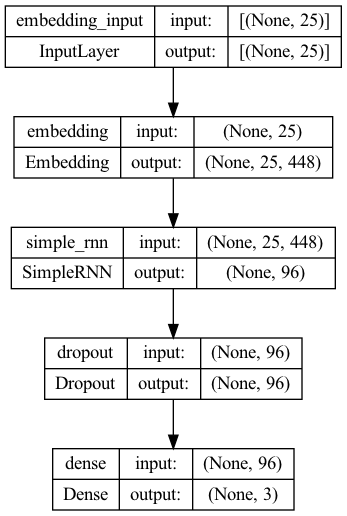

In [18]:
tf.keras.utils.plot_model(best_model_1, to_file='../plots/model_plots/rnn_model_1.png', show_shapes=True)

In [19]:
y_pred = best_model_1.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

  1/338 [..............................] - ETA: 1:06

2023-01-13 14:36:09.335725: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_201868"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:739"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

338/338 [==============================] - 11s 33ms/step


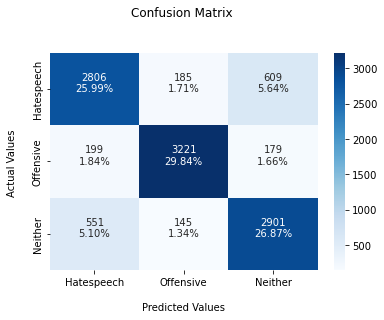

In [20]:
plotConfusionMatrix(cm)

In [21]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      3600
           1       0.91      0.89      0.90      3599
           2       0.79      0.81      0.80      3597

    accuracy                           0.83     10796
   macro avg       0.83      0.83      0.83     10796
weighted avg       0.83      0.83      0.83     10796



In [22]:
best_model_1.save('../models/rnn_model_1')

INFO:tensorflow:Assets written to: ../models/rnn_model_1/assets


### Find best model for 20 epochs of training

In [23]:
tuner_2, best_model_2 = tuneModelByEpoch(20, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 2)

Trial 5 Complete [01h 27m 44s]
val_accuracy: 0.8212300539016724

Best val_accuracy So Far: 0.8397554755210876
Total elapsed time: 08h 43m 25s
INFO:tensorflow:Oracle triggered exit


In [24]:
tuner_2.results_summary()

Results summary
Results in ../tuner_dir/rnn_tuner_2/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 352
units: 32
dropout: False
lr: 0.0004939443094529306
batch_size: 32
Score: 0.8397554755210876
Trial summary
Hyperparameters:
output_dim: 256
units: 128
dropout: True
lr: 0.0005794155666227713
batch_size: 128
rate: 0.2
Score: 0.8290107250213623
Trial summary
Hyperparameters:
output_dim: 224
units: 320
dropout: True
lr: 0.0003372778431600531
batch_size: 64
rate: 0.21191841548881868
Score: 0.8212300539016724
Trial summary
Hyperparameters:
output_dim: 224
units: 416
dropout: False
lr: 0.0007037773259220206
batch_size: 32
Score: 0.8120599985122681
Trial summary
Hyperparameters:
output_dim: 384
units: 416
dropout: False
lr: 0.004973292104754128
batch_size: 64
rate: 0.43721560631631373
Score: 0.3781956136226654


In [25]:
best_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 352)           10147808  
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                12320     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 10,160,227
Trainable params: 10,160,227
Non-trainable params: 0
_________________________________________________________________


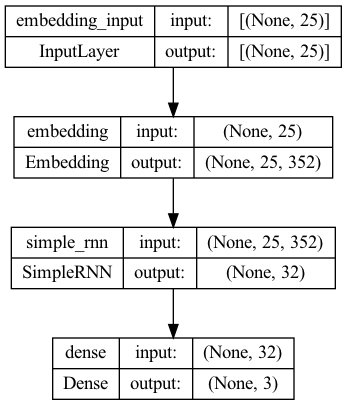

In [26]:
tf.keras.utils.plot_model(best_model_2, to_file='../plots/model_plots/rnn_model_2.png', show_shapes=True)

In [27]:
y_pred = best_model_2.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

2023-01-13 23:19:48.449501: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_757903"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2048"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

338/338 [==============================] - 14s 36ms/step


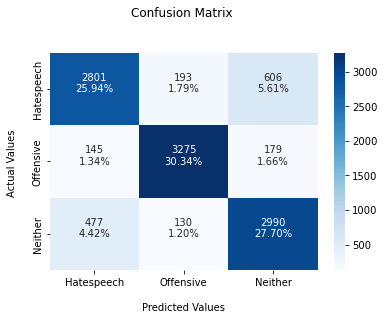

In [28]:
plotConfusionMatrix(cm)

In [29]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      3600
           1       0.91      0.91      0.91      3599
           2       0.79      0.83      0.81      3597

    accuracy                           0.84     10796
   macro avg       0.84      0.84      0.84     10796
weighted avg       0.84      0.84      0.84     10796



In [30]:
best_model_2.save('../models/rnn_model_2')

INFO:tensorflow:Assets written to: ../models/rnn_model_2/assets


### Find best model for 30 epochs of training

In [15]:
tuner_3, best_model_3 = tuneModelByEpoch(30, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 3)

Trial 5 Complete [02h 57m 34s]
val_accuracy: 0.7496294975280762

Best val_accuracy So Far: 0.8299369812011719
Total elapsed time: 07h 55m 14s
INFO:tensorflow:Oracle triggered exit


In [16]:
tuner_3.results_summary()

Results summary
Results in ../tuner_dir/rnn_tuner_3/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 192
units: 160
dropout: True
lr: 0.00011899650093290271
rate: 0.49588191232298023
batch_size: 64
Score: 0.8299369812011719
Trial summary
Hyperparameters:
output_dim: 64
units: 384
dropout: True
lr: 0.000598588036309128
rate: 0.4397920164738949
batch_size: 32
Score: 0.823638379573822
Trial summary
Hyperparameters:
output_dim: 192
units: 256
dropout: False
lr: 0.001212158724708745
rate: 0.2835438990203588
batch_size: 32
Score: 0.7496294975280762
Trial summary
Hyperparameters:
output_dim: 288
units: 416
dropout: True
lr: 0.0018151801415464167
rate: 0.2
batch_size: 32
Score: 0.41450536251068115
Trial summary
Hyperparameters:
output_dim: 352
units: 416
dropout: True
lr: 0.007195712607074813
rate: 0.4128136152449483
batch_size: 32
Score: 0.359485000371933


In [17]:
best_model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 192)           5535168   
                                                                 
 simple_rnn (SimpleRNN)      (None, 160)               56480     
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 3)                 483       
                                                                 
Total params: 5,592,131
Trainable params: 5,592,131
Non-trainable params: 0
_________________________________________________________________


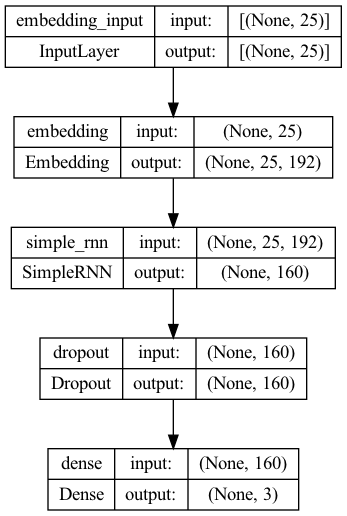

In [18]:
tf.keras.utils.plot_model(best_model_3, to_file='../plots/model_plots/rnn_model_3.png', show_shapes=True)

In [19]:
y_pred = best_model_3.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

  1/338 [..............................] - ETA: 1:05

2023-01-15 19:56:28.695672: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1120758"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1839"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

338/338 [==============================] - 11s 31ms/step


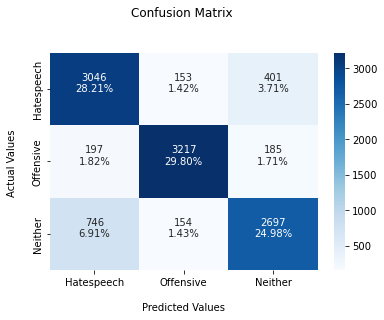

In [20]:
plotConfusionMatrix(cm)

In [21]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      3600
           1       0.91      0.89      0.90      3599
           2       0.82      0.75      0.78      3597

    accuracy                           0.83     10796
   macro avg       0.83      0.83      0.83     10796
weighted avg       0.83      0.83      0.83     10796



In [22]:
best_model_3.save('../models/rnn_model_3')

INFO:tensorflow:Assets written to: ../models/rnn_model_3/assets
